# Script to explore finding and fitting transits with LightKurve and other packages
### Last modified 6/25/21 by Anna Zuckerman


In [ ]:
!pip install lightkurve

In [ ]:
pip install --pre --upgrade astroquery

In [98]:
# import packages
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import numpy as np

In [99]:
# get planet properties from NASA Exoplanet Archive <-- is this table deprecated??
planet_name  = 'kepler-69b'
planet = NasaExoplanetArchive.query_object(planet_name)
period = np.nanmedian(planet['pl_orbper']).value # Planet period [Days]
duration = np.nanmedian(planet['pl_trandur']).value # Planet transit duration [Days]
t0 = np.nanmedian(planet['pl_tranmid']).value # Transit midpoint (??) [Days]
R_p = np.nanmedian(planet['pl_rade']).value * 0.0091577 # Planet radius [Ro]
R_star = np.nanmedian(planet['st_rad']).value  # Star radius [Ro]
impact_parameter = np.nanmedian(planet['pl_imppar']) # impact parameter 
RpRs = R_p/R_star # Planet star radius ratio = sqrt(transit depth)

print('period: ' + str(np.round(period,3)))
print('duration: ' + str(np.round(duration,3)))
print('t0: ' + str(np.round(t0,3)))
print('RpRs: ' + str(np.round(RpRs,3)))
print('impact parameter: ' + str(np.round(impact_parameter,3)))
#print('expected number points per 1/2 period transit fitting window: ' + str(expected_points_per_window))

period: 13.722
duration: 5.155
t0: 2454970.841
RpRs: 0.022
impact parameter: 0.254


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:3636: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


In [100]:
# search for and download all lightcurves
obs_type = 'kepler'
planet_name = 'kepler-69 b'
star_name = 'kepler-69'
search_result = lk.search_lightcurve(star_name, author=obs_type, cadence='long')
lc_collection = search_result.download_all()
lc = lc_collection.stitch().remove_outliers()
flux = lc.flux.value           # Flux [relative units]
time = lc.time.value + 2454833 # Time  [BKJD days]
flux_err = lc.flux_err.value   # Uncertainty in flux
dt = np.median(np.diff(time))  # [Days] Usual timestep size (should matach cadence, except for example missing data)
flux_SD = np.std(flux)         # Standard deviation in flux
mean_flux_err = np.nanmean(flux_err)  # Mean error in flux 


# stitch together, flatten, and normalize all observations
window_length = int(duration) # int(1/dt)   # ideally this would be 3-4 * transit duration, but duration is not known until transit is modelled. So for now we consider 24hrs.
if window_length % 2 == 0: # length must be odd for built in lightkurve smooting function
    window_length += 1
lc = lc.flatten(window_length)

# assesss quality flags and remove bad data
quality = lc.quality
good_data_flag = (quality == 0) * (flux_err > 0) * (np.isfinite(time)) * (np.isfinite(flux)) * (np.isfinite(flux_err)) 
time = time[good_data_flag]
flux = flux[good_data_flag]
flux_err = flux_err[good_data_flag]

num_transits = int(np.floor((time[-1] - t0) / period))
# FOR TESTING ONLY
shift_value = 1/8#period/3 # --> for testing regions with no transi
#               also can do 30min, 1hr, 2hr ect to simply shift transit
#time = time + shift_value  # shift time 

In [101]:
# get cadence information
cadence_type = lc.meta['OBSMODE'] 
if obs_type == 'Kepler' or obs_type == 'kepler':
    if cadence_type == 'long cadence':
        cadence = 1764 # sec
    if cadence_type == 'short cadence':
        cadence = 58.85 # sec   
        
if obs_type == 'TESS':
    print('TESS CADENCE INFO NOT YET IMPLEMENTED!')


Text(0.5, 1.0, 'Kepler-69 b')

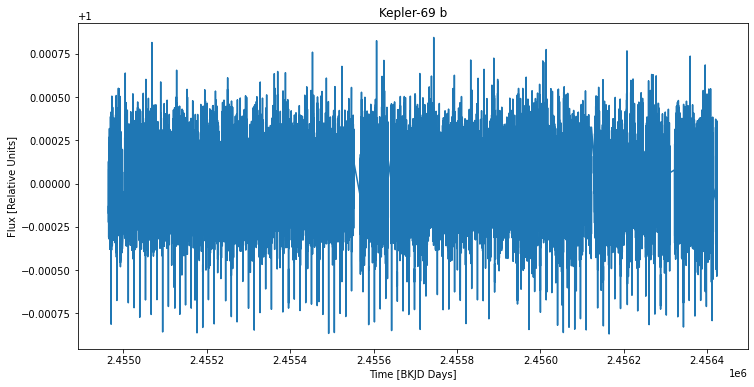

In [102]:
# plot lightcurve

plt.figure(figsize = [12,6])
plt.plot(time, flux)
plt.xlabel('Time [BKJD Days]')
plt.ylabel('Flux [Relative Units]')
plt.title('Kepler-69 b')


In [103]:
# Known properties of the transit from NASA Exoplanet Archive
# [NOTE: NEED TO DO THIS PROGRAMATICALLY!]

#period = 13.722                               # Days
#t0 = 2454970.84                               # Days
#R_p = 2.28                                    # Earth radii
#R_star = 1.04                                 # Ro [NOTE: this is an average of exoplanet archive values]
#R_p_star = (R_p * 6378.14)/(R_star * 696340)  # Rp/R* 
#a = 0.10                                      # AU
#inc = 89.4                                    # Inclination [deg]
#ecc = 0                                       # Ecentricity (NOTE: Barclay et al. 2013 says 0.16 +0.17/-0.001)
#w = #???                                     # [NOT LISTED IN NASA TABLE]
#u = #???                                     # [NOT LISTED IN NASA TABLE]
#limb_darkening_model = 'quadratic'
#impact_parameter = 0.254                      # NOTE: This is mode but varies widely in NASA Exoplanet Archive table

## Fit transits as Gaussians

In [104]:
fit_window_size = 0.125/2    # Fraction of period on both sides of the expected transit midpoints to fit for transit
inner_window_size = 0.125/2*0.5 # Fraction of period on both sides of expected midpoint to check for missing data
expected_points_per_inner_window = np.floor((period * 24 * 60 * 60 * inner_window_size*2) / cadence)

In [ ]:
# fit guassian to transits using known t0 as guessed location, RpRs for guessed depth

def fit_func(func_type, transit_idx, verbosity):

    # area around expected transit
    low_bound = t0 + period * transit_idx - period * fit_window_size    
    up_bound = t0 + period * transit_idx + period * fit_window_size
    # all intervals are ~same in time duration, but not in number of steps/pixels
    interval = (low_bound < time)*(time < up_bound)
    time_interval = np.max(time[time < up_bound]) -  np.min(time[time > low_bound])
    length = len(time[interval])
    
    # for checking that datapoints immediatley around transit is not missing
    # becuase the location of the missing data within the transit window mattters
    inner_low_bound = t0 + period * transit_idx - period * inner_window_size    
    inner_up_bound = t0 + period * transit_idx + period * inner_window_size
    # all intervals are ~same in time duration, but not in number of steps/pixels
    inner_interval = (inner_low_bound < time)*(time < inner_up_bound)
    inner_time_interval = np.max(time[time < inner_up_bound]) -  np.min(time[time > inner_low_bound])
    inner_length = len(time[inner_interval])
    
    if verbosity == 2:
         print(length)
    apply_thresholds = 1
    min_points_threshold = expected_points_per_inner_window * 0.90
    if apply_thresholds:
        if (inner_length < min_points_threshold):
            print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')          
            return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan
    
    print('Modelling transit ' + str(transit_idx))

    # fit a function to the transit
    if fit_type == 'g':
        def gaussian(x, a, b, c):
            return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))
        guess_params = [-0.1, t0 + period * transit_idx, 0.1] # somewhat arbitrary, but seems like a < 0 works, b = t0, and 0.01 < c < 10 
        pars, cov = curve_fit(f=gaussian, xdata=time[interval], ydata=flux[(interval)]-1, p0 = guess_params, bounds=([-np.inf, low_bound, -np.inf],[np.inf, up_bound, np.inf]), maxfev = 80000)
        print(pars[2])
        model_function = pars[0]*np.exp((-(time[interval]-pars[1])**2)/(2*pars[2])**2) + 1
        k = 3 # DOF
    elif fit_type == 'g+p':
        def gauss_poly1(x, a, b, c, d, e):
            return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2))) + (d*x + e)
        guess_params = [-0.1, t0 + period * transit_idx, 0.1,1,1] # 1 is the default so for the last three this is basically setting no guess
        pars, cov = curve_fit(f=gauss_poly1, xdata=time[interval], ydata=flux[(interval)]-1, p0 = guess_params, bounds=([-np.inf, low_bound, -np.inf, -np.inf, -np.inf],[np.inf, up_bound, np.inf, np.inf, np.inf]), maxfev = 80000)
        #model_function = pars[0]*np.exp((-(time[interval]-pars[1])**2)/(2*pars[2])**2) + 1 
        model_function = gauss_poly1(time[interval], pars[0], pars[1], pars[2], pars[3], pars[4]) + 1
        k = 5
    elif fit_type == 'p':
        def poly1(x, a, b):
            return a*x + b
        pars, cov = curve_fit(f=poly1, xdata=time[interval], ydata=flux[(interval)]-1, bounds=(-np.inf, np.inf), maxfev = 80000)
        #model_function = pars[0]*np.exp((-(time[interval]-pars[1])**2)/(2*pars[2])**2) + 1 
        model_function = poly1(time[interval], pars[0], pars[1]) + 1
        k = 2
    else: 
        print('Fit type must be \'g\' (gaussian), \'g+p\' (gaussian + polynomial), or \'p\' (polynomial)')
    resids = flux[interval] - model_function
    RMSE = np.sqrt(np.sum(resids**2/length))
    chi_sq = np.sum((resids**2)/flux_err[interval])
    #print(chi_sq)
    BIC = chi_sq + k*np.log(length) # bayesian information criterion

    if verbosity == 1:   
        plt.figure(figsize = [8,4])
        plt.plot(time[interval], flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
        plt.plot(time[interval], model_function, label = 'fit')
        #plt.axvline(pars[1], label = 'fit midpoint
        plt.axvline(t0 + period * transit_idx, label = 'expected midpoint', color = 'k')
        #plt.axvline(pars[1], label = 'fit midpoint', color = 'red')
        plt.legend()
        plt.xlabel('Time [BKJD Days]')
        plt.ylabel('Flux [Relative Units]')
        plt.title('Kepler-69 b, transit ' + str(transit_idx))
        #print('Gaussian parameters for transit ' + str(transit_idx) +':')
        #print('     a = ' + str(np.round(pars[0],4)))
        #print('     b = ' + str(np.round(pars[1],3)))
        #print('     c = ' + str(np.round(pars[2],4)))
        #print('     RMSE = ' + str(np.round(RMSE,4)))
        #print()
    return(pars, RMSE, chi_sq, BIC, length, inner_length, time_interval)
 

expected_midpoints = np.arange(t0, t0 + (num_transits) * period, period)
time_intervals = [] # store time intervals of each transit window
skipped = [] # record which transit idxs are skipped

fit_type = input('Enter fit function type (g,p, or g+p): ')
verbosity = 1
if fit_type == 'g+p':
    RMSE_arr_gp = [] # store RMSE of the fit to each transit
    BIC_arr_gp = [] # store BIC of the fit to each transit
    chi_sq_arr_gp = [] # store chi square of the fit to each transit
    midpoints_gp = [] # store midpoints of all transits
    depths_gp = [] # store transit depths
    lengths_gp = [] # store number of points in each transit interval window
    inner_lengths_gp = [] # store number of points in transit window near transit
    for transit_idx in np.linspace(0,num_transits-1,num_transits):
        try:
            pars, RMSE, chi_sq, BIC, length, inner_length, time_interval = fit_func(fit_type, transit_idx, verbosity)
        except ValueError:
            print('skipped transit' + str(transit_idx))
            pars, RMSE, chi_sq, BIC, length, inner_length, time_interval = [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        depths_gp += [pars[0]]
        midpoints_gp += [pars[1]]
        lengths_gp += [length]
        inner_lengths_gp += [inner_length]
        RMSE_arr_gp += [RMSE]
        BIC_arr_gp += [BIC]
        chi_sq_arr_gp += [chi_sq]
        time_intervals += [time_interval] 
        if np.isnan(pars[0]):
            skipped += [1]
        else: skipped += [0]
    chi_sq_arr_gp = np.array(chi_sq_arr_gp)
    depths_gp = np.array(depths_gp) 
    midpoints_gp = np.array(midpoints_gp)
    mean_transit_depth = np.nanmean(depths_gp)
    expected_depth = -RpRs**2
    delta_depths_gp = expected_depth - depths_gp 
    delta_midpoints_gp = expected_midpoints - midpoints_gp 
elif fit_type == 'p':
    RMSE_arr_p = [] # store RMSE of the fit to each transit
    BIC_arr_p = [] # store BIC of the fit to each transit
    chi_sq_arr_p = [] # store chi square of the fit to each transit
    midpoints_p = [] # store midpoints of all transits
    depths_p = [] # store transit depths
    lengths_p = [] # store number of points in each transit interval window
    inner_lengths_p = [] # store number of points in transit window near transit
    for transit_idx in np.linspace(0,num_transits-1,num_transits):
        try:
            pars, RMSE, chi_sq, BIC, length, inner_length, time_interval = fit_func(fit_type, transit_idx, verbosity)
        except ValueError:
            print('skipped transit' + str(transit_idx))
            pars, RMSE, chi_sq, BIC,  length, inner_length, time_interval = [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        RMSE_arr_p += [RMSE]
        BIC_arr_p += [BIC]
        chi_sq_arr_p += [chi_sq]
        if np.isnan(pars[0]):
            skipped += [1]
        else: skipped += [0]
    chi_sq_arr_p = np.array(chi_sq_arr_p)
elif fit_type == 'g':
    RMSE_arr_g = [] # store RMSE of the fit to each transit
    BIC_arr_g = [] # store BIC of the fit to each transit
    chi_sq_arr_g = [] # store chi square of the fit to each transit
    midpoints_g = [] # store midpoints of all transits
    depths_g = [] # store transit depths
    lengths_g = [] # store number of points in each transit interval window
    inner_lengths_g = [] # store number of points in transit window near transit
    for transit_idx in np.linspace(0,num_transits-1,num_transits):
        try:
            pars, RMSE, chi_sq, BIC, length, inner_length, time_interval = fit_func(fit_type, transit_idx, verbosity)
        except ValueError:
            print('skipped transit' + str(transit_idx))
            pars, RMSE, chi_sq, BIC,  length, inner_length, time_interval = [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        depths_g += [pars[0]]
        midpoints_g += [pars[1]]
        lengths_g += [length]
        inner_lengths_g += [inner_length]
        RMSE_arr_g += [RMSE]
        BIC_arr_g += [BIC]
        chi_sq_arr_g += [chi_sq]
        time_intervals += [time_interval] 
        if np.isnan(pars[0]):
            skipped += [1]
        else: skipped += [0]
    chi_sq_arr_g = np.array(chi_sq_arr_g)
    depths_g = np.array(depths_g) # gp == gaussian + polynomial
    midpoints_g = np.array(midpoints_g)
    mean_transit_depth = np.nanmean(depths_g)
    expected_depth = -RpRs**2
    delta_depths_g = expected_depth - depths_g
    delta_midpoints_g = expected_midpoints - midpoints_g
skipped  = np.array(skipped)

print()

print(str(len(skipped[skipped == 1])) + ' transits skipped out of ' + str(num_transits) + ' total transits.')

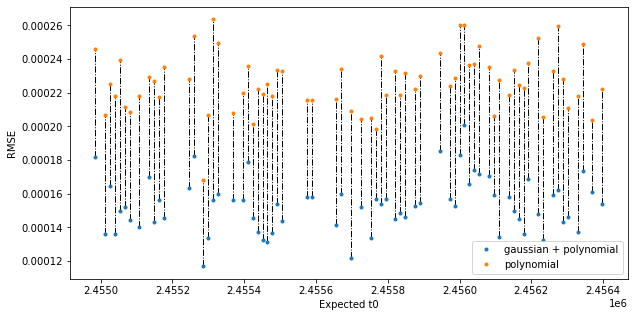

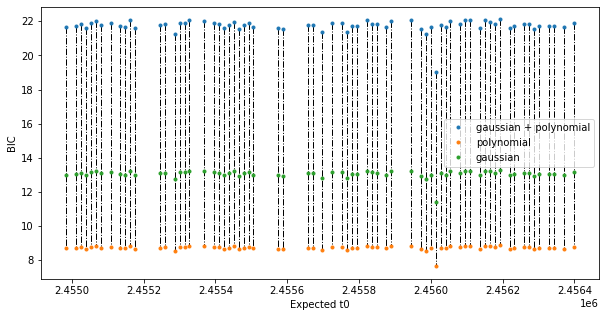

In [108]:
# Is each transit better fit by polynomial (no transit) or gaussian + polynomial (transit)
plt.figure(figsize = [10,5])
plt.plot(expected_midpoints, RMSE_arr_gp, '.', label = 'gaussian + polynomial')
plt.plot(expected_midpoints, RMSE_arr_p, '.', label = 'polynomial')
plt.vlines(x = expected_midpoints, ymin = RMSE_arr_gp, ymax = RMSE_arr_p, color = 'k', lw = 1, ls = '-.')
plt.xlabel('Expected t0'); plt.ylabel('RMSE'); plt.legend()


plt.figure(figsize = [10,5])
plt.plot(expected_midpoints, BIC_arr_gp, '.', label = 'gaussian + polynomial')
plt.plot(expected_midpoints, BIC_arr_p, '.', label = 'polynomial')
plt.plot(expected_midpoints, BIC_arr_g, '.', label = 'gaussian')
plt.vlines(x = expected_midpoints, ymin = BIC_arr_gp, ymax = BIC_arr_p, color = 'k', lw = 1, ls = '-.')
plt.xlabel('Expected t0'); plt.ylabel('BIC'); plt.legend()

In [ ]:
# Determine quality thresholds on goodness of fit and amount of data in each fit

# RMSE threshold
plt.figure(figsize = [14,15])
plt.subplot(421)
plt.plot(RMSE_arr_g, delta_depths_g,'.')
#plt.yscale('symlog')
plt.xlabel('RMSE'); plt.ylabel('Transit depth - mean depth')
plt.subplot(422)
plt.plot(RMSE_arr_g, delta_midpoints_g,'.')
#plt.yscale('symlog')
plt.xlabel('RMSE'); plt.ylabel('Midpoint - expected midpoint')

# transit window time interval threshold
#plt.figure(figsize = [14,5])
plt.subplot(423)
plt.plot(time_intervals, delta_depths_g,'.')
#plt.yscale('symlog')
plt.xlabel('Time interval [days]'); plt.ylabel('Transit depth - mean depth')
plt.subplot(424)
plt.plot(time_intervals, delta_midpoints_g,'.')
#plt.yscale('symlog')
plt.xlabel('Time interval [days]'); plt.ylabel('Midpoint - expected midpoint')

# transit window number of data points threshold
#plt.figure(figsize = [14,5])
plt.subplot(425)
plt.plot(lengths, delta_depths_g,'.')
plt.xlabel('Data points in window'); plt.ylabel('Transit depth - mean depth')
plt.subplot(426)
plt.plot(lengths, delta_midpoints_g,'.')
plt.xlabel('Data points in window'); plt.ylabel('Midpoint - expected midpoint')

# inner transit window (ie. closer to transit) number of data points threshold
#plt.figure(figsize = [14,5])
plt.subplot(427)
plt.plot(inner_lengths, delta_depths_g,'.')
plt.xlabel('Data points in inner window'); plt.ylabel('Transit depth - mean depth')
plt.subplot(428)
plt.plot(inner_lengths, delta_midpoints_g,'.')
plt.xlabel('Data points in inner window'); plt.ylabel('Midpoint - expected midpoint')


Text(0.5, 0.98, 'Guassian fitting')

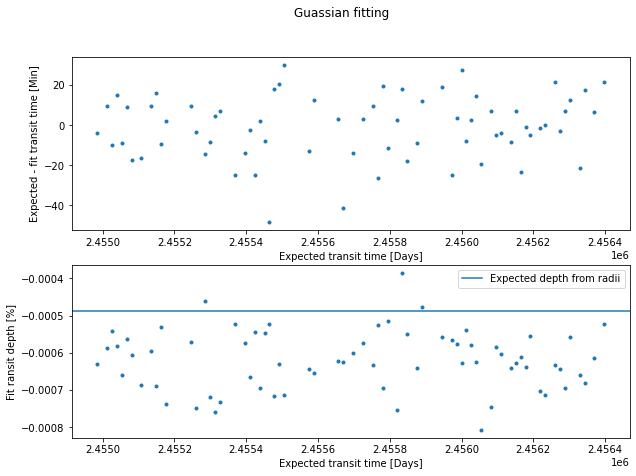

In [112]:
# make O-C plots (expected - observed transit times as a functions of expected)

plt.figure(figsize = [10,7])
plt.subplot(211)
plt.plot(expected_midpoints, delta_midpoints_g * 1440, '.')
plt.xlabel('Expected transit time [Days]'); plt.ylabel('Expected - fit transit time [Min]')

plt.subplot(212)
plt.plot(expected_midpoints, depths_g, '.')
plt.axhline(expected_depth, label = 'Expected depth from radii')
plt.xlabel('Expected transit time [Days]'); plt.ylabel('Fit ransit depth [%]')
plt.legend()

plt.suptitle('Guassian fitting')

## Fit transits with ktransit
#### Modified from tutorial at https://github.com/mrtommyb/ktransit

In [484]:
!pip install ktransit

Defaulting to user installation because normal site-packages is not writeable


In [92]:
import ktransit
from ktransit import FitTransit

Best-fitting stellar parameters

Best-fitting planet parameters for planet 0
T0: 2454970.84083
rprs: 0.022094768253968253



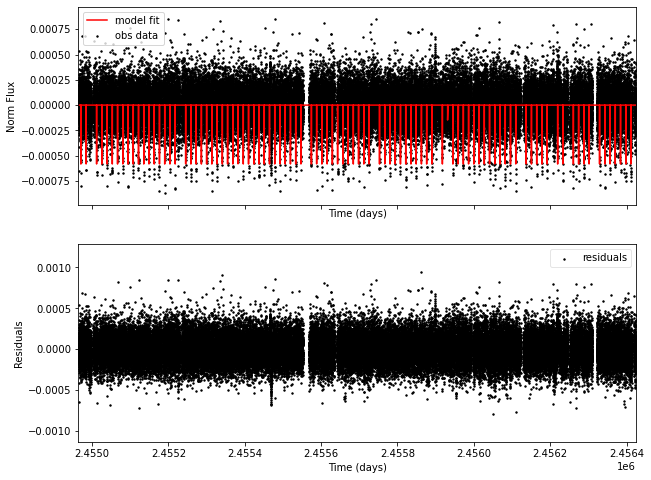

In [93]:
# fit the entire lightcurve

fitT = FitTransit()
fitT.add_guess_star()    
fitT.add_guess_planet(period=period, impact=impact_parameter, T0=t0, rprs=RpRs)
fitT.add_data(time=time, flux=flux -1, ferr=err)

vary_star = []                     # free stellar parameters
vary_planet = (['T0',  'rprs'])    # free planetary parameters

fitT.free_parameters(vary_star, vary_planet)
fitT.do_fit()                      # run the fitting

fitT.print_results()               # print some results

fig = ktransit.plot_results(time,flux-1,fitT.transitmodel) 
fig.show()

In [ ]:
# fit one transit

def fit_ktransit(transit_idx, to_plot, verbosity):
    skip = 0
    
    # area around expected transit
    low_bound = t0 + period * transit_idx - period * fit_window_size     
    up_bound = t0 + period * transit_idx + period * fit_window_size 
    interval = (low_bound < time)*(time < up_bound)
    length = len(time[interval])
    
    # for checking that datapoints immediatley around transit is not missing
    # becuase the location of the missing data within the transit window mattters
    inner_low_bound = t0 + period * transit_idx - period * inner_window_size     
    inner_up_bound = t0 + period * transit_idx + period * inner_window_size 
    # all intervals are ~same in time duration, but not in number of steps/pixels
    inner_interval = (inner_low_bound < time)*(time < inner_up_bound)
    inner_time_interval = np.max(time[time < inner_up_bound]) -  np.min(time[time > inner_low_bound])
    inner_length = len(time[inner_interval])
    
    if verbosity == 2:
    #    print(low_bound); print(up_bound)
    #    print(np.min(time[time > low_bound])); print(np.max(time[time < up_bound]))
    #    print(time_interval)
    #    plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
         print(length)
    apply_thresholds = 1
    min_points_threshold = expected_points_per_inner_window * 0.90
    if apply_thresholds:
        if (inner_length < min_points_threshold):
            print('Could not model transit ' + str(transit_idx) + ' (due to missing data).')  
            print()
            skip = 1
            #return [np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan, skip
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, skip
    
    print('Modelling transit ' + str(transit_idx))

    fitT = FitTransit()
    fitT.add_guess_star()    
    fitT.add_guess_planet(period=period, impact=impact_parameter, T0=t0 + transit_idx*period, rprs=RpRs)
    fitT.add_data(time=time[interval], flux=flux[interval] - 1, ferr=err[interval])

    vary_star = []                     # free stellar parameters
    vary_planet = (['T0',  'rprs'])    # free planetary parameters

    fitT.free_parameters(vary_star, vary_planet)
    fitT.do_fit()                      # run the fitting
    fit_t0 = fitT.fitresultplanets['pnum0']['T0']
    fit_rprs = fitT.fitresultplanets['pnum0']['rprs']
    
    #fitT.print_results()               # print some results
    RMSE = np.sqrt(np.sum(((flux[interval] - 1) - fitT.transitmodel)**2/length))
    print('t0 = ' + str(np.round(fit_t0,4)))
    print('rprs = ' + str(np.round(fit_rprs,4)))
    print('RMSE = ' + str(np.round(RMSE,4)))
    print()
    
    if to_plot:
        #fig = ktransit.plot_results(time[(low_bound < time)*(time < up_bound)],flux[(low_bound < time)*(time < up_bound)]-1,fitT.transitmodel) 
        #plt.title('Kepler-69 b, transit ' + str(transit_idx))
        #fig.show()
        plt.figure(figsize = [12,6])
        plt.plot(time[interval],flux[interval] - 1 , '.', markersize = 5,label = 'Kepler-69b Data')
        plt.plot(time[interval], fitT.transitmodel, label = 'ktransit fit')
        plt.axvline(fit_t0)
        plt.legend()
        plt.xlabel('Time [BKJD Days]')
        plt.ylabel('Flux [Relative Units]')
        plt.title('Kepler-69 b, transit ' + str(transit_idx))
        
        #fig = ktransit.plot_results(time[interval],flux[interval],fitT.transitmodel)
        #fig.show()
    
    return fit_t0, fit_rprs, RMSE, length, inner_length, time_interval, skip
    

num_transits = int(np.floor((time[-1] - t0) / period))
expected_midpoints = np.arange(t0, t0 + (num_transits) * period, period)
fit_t0_arr = [] # store midpoints of all transits
depths = [] # store transit depths
lengths = [] # store number of points in each transit interval window
inner_lengths = [] # store number of points in transit window near transit
time_intervals = [] # store time intervals of each transit window
RMSE_arr = [] # store RMSE of the fit to each transit
skipped = [] # record which transit idxs are skipped
fit_t0_arr = [] # record transit midpoint (?) values from the fit
fit_rprs_arr = [] # record planet to star radius ratio from the fit
for transit_idx in np.linspace(0,num_transits-1,num_transits):
    #try: 
    fit_t0, fit_rprs, RMSE, length, inner_length, time_interval, skip = fit_ktransit(transit_idx, to_plot = 0, verbosity = 0)
    #except ValueError:
    #    print('skipped transit ' + str(transit_idx))
    #    print()
    #    fit_t0, fit_rprs, RMSE, length, inner_length, time_interval, skip = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, skip
    #    skip = 1
    fit_t0_arr += [fit_t0]
    fit_rprs_arr += [fit_rprs]
    lengths += [length]
    inner_lengths += [inner_length]
    RMSE_arr += [RMSE]
    time_intervals += [time_interval]
    if skip:
        skipped += [transit_idx]

midpoints_k = fit_t0_arr
depths_k = np.array(fit_rprs_arr)**2 # is this correct?       
mean_transit_depth = np.nanmean(depths_k)
delta_depths_k = mean_transit_depth - depths_k # k == ktransit
delta_midpoints_k = expected_midpoints - fit_t0_arr # k == ktransit [is this correct?]

print()
print(str(len(skipped)) + ' transits skipped out of ' + str(num_transits) + ' total transits.')

Text(0, 0.5, 'Midpoint - expected midpoint')

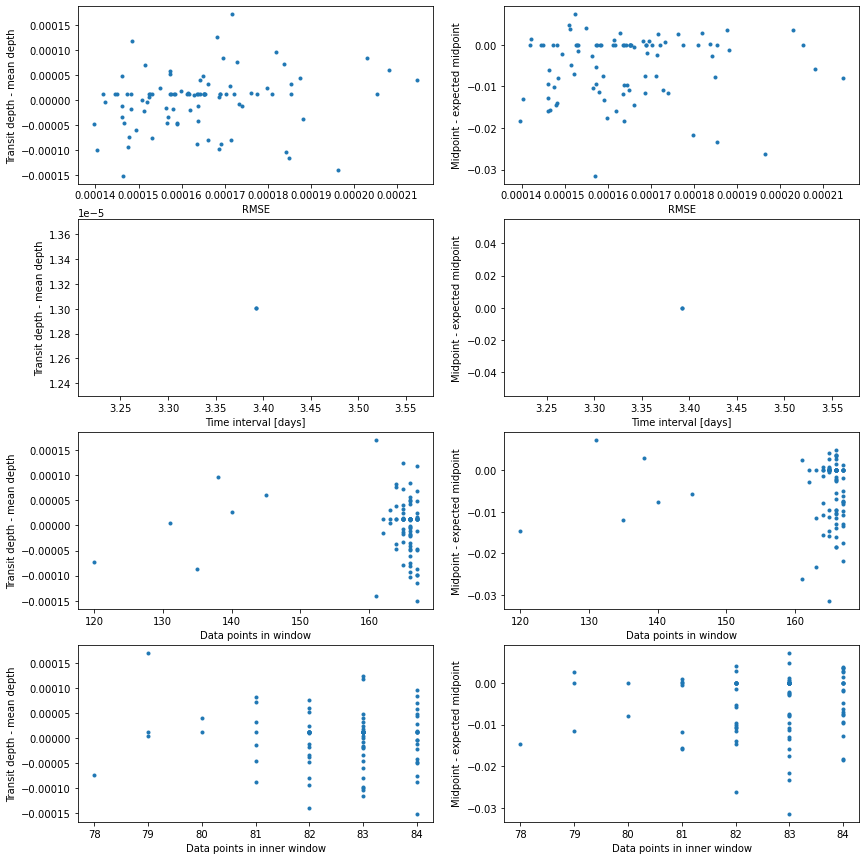

In [95]:
# Determine quality thresholds on goodness of fit and amount of data in each fit

# RMSE threshold
plt.figure(figsize = [14,15])
plt.subplot(421)
plt.plot(RMSE_arr, delta_depths_k,'.')
#plt.yscale('symlog')
plt.xlabel('RMSE'); plt.ylabel('Transit depth - mean depth')
plt.subplot(422)
plt.plot(RMSE_arr, delta_midpoints_k,'.')
#plt.yscale('symlog')
plt.xlabel('RMSE'); plt.ylabel('Midpoint - expected midpoint')

# transit window time interval threshold
#plt.figure(figsize = [14,5])
plt.subplot(423)
plt.plot(time_intervals, delta_depths_k,'.')
#plt.yscale('symlog')
plt.xlabel('Time interval [days]'); plt.ylabel('Transit depth - mean depth')
plt.subplot(424)
plt.plot(time_intervals, delta_midpoints_k,'.')
#plt.yscale('symlog')
plt.xlabel('Time interval [days]'); plt.ylabel('Midpoint - expected midpoint')

# transit window number of data points threshold
#plt.figure(figsize = [14,5])
plt.subplot(425)
plt.plot(lengths, delta_depths_k,'.')
plt.xlabel('Data points in window'); plt.ylabel('Transit depth - mean depth')
plt.subplot(426)
plt.plot(lengths, delta_midpoints_k,'.')
plt.xlabel('Data points in window'); plt.ylabel('Midpoint - expected midpoint')

# inner transit window (ie. closer to transit) number of data points threshold
#plt.figure(figsize = [14,5])
plt.subplot(427)
plt.plot(inner_lengths, delta_depths_k,'.')
plt.xlabel('Data points in inner window'); plt.ylabel('Transit depth - mean depth')
plt.subplot(428)
plt.plot(inner_lengths, delta_midpoints_k,'.')
plt.xlabel('Data points in inner window'); plt.ylabel('Midpoint - expected midpoint')


## Understand variation and explore threshold values

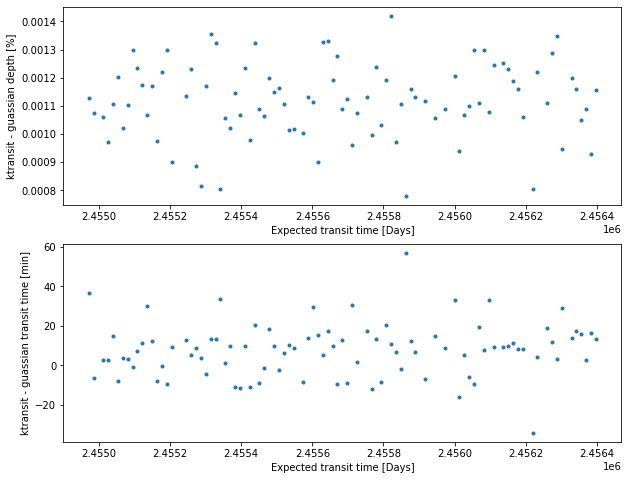

In [199]:
# differences between gaussian and ktransit fitting

plt.figure(figsize = [10,8])
plt.subplot(211)
diff_k_g_depth = depths_k - depths_g
plt.plot(expected_midpoints, diff_k_g_depth, '.')
plt.xlabel('Expected transit time [Days]')
plt.ylabel('ktransit - guassian depth [%]')

plt.subplot(212)
diff_k_g_midpoint = (midpoints_k - midpoints_g) * 1400
plt.plot(expected_midpoints, diff_k_g_midpoint, '.')
plt.xlabel('Expected transit time [Days]')
plt.ylabel('ktransit - guassian transit time [min]')

tt_sd_diff_k_g= np.nanstd(diff_k_g_midpoint) # standard deviation in expected minus fit transit midpoints
tt_max_diff_k_g = np.nanmax(np.abs(diff_k_g_midpoint))
depth_sd_diff_k_g = np.nanstd(diff_k_g_depth)
depth_max_diff_k_g = np.nanmax(np.abs(diff_k_g_depth))

In [42]:
# determine overall variability in transit timings and depths
sd_ttv_gp = np.nanstd(delta_midpoints_gp) # standatd deviation in expected minus fit transit midpoints
max_ttv_gp = np.nanmax(np.abs(delta_midpoints_gp)) # max delta in transit timing 
mean_ttv_gp = np.nanmean(delta_midpoints_gp) # mean ttv 
sd_delta_depth_gp = np.nanstd(delta_depths_gp)
max_delta_depth_gp = np.nanmax(np.abs(delta_depths_gp))
mean_delta_depth_gp = np.nanmean(delta_depths_gp)

print('TTV\'s: max abs tt variation ' + "{:.2e}".format(max_ttv_gp) + ' [min], standard deviation ' + "{:.2e}".format(sd_ttv_gp * 1440) + ' [min], mean tt variation ' + "{:.2e}".format(mean_ttv_gp) )
print('Depths: max variation ' + "{:.2e}".format(max_delta_depth_gp) + ', standard deviation ' + "{:.2e}".format(sd_delta_depth_gp))

TTV's: max abs tt variation 1.98e-01 [min], standard deviation 3.32e+01 [min], mean tt variation -1.79e-03
Depths: max variation 3.90e-04, standard deviation 9.99e-05


In [194]:
# determine overall variability in transit timings and depths
sd_ttv_k = np.nanstd(delta_midpoints_k) # standatd deviation in expected minus fit transit midpoints
max_ttv_k = np.nanmax(np.abs(delta_midpoints_k)) # max delta in transit timing 
mean_ttv_k = np.nanmean(delta_midpoints_k) # absolute value mean ttv 
sd_delta_depth_k = np.nanstd(delta_depths_k)
max_delta_depth_k = np.nanmax(np.abs(delta_depths_k))
mean_delta_depth_k = np.nanmean(np.abs(delta_depths_k))

print('TTV\'s: max abs tt variation ' + "{:.2e}".format(max_ttv_k) + ' [min], standard deviation ' + "{:.2e}".format(sd_ttv_k * 1440) + ' [min]')
print('Depths: max variation ' + "{:.2e}".format(max_delta_depth_k) + ', standard deviation ' + "{:.2e}".format(sd_delta_depth_k))


TTV's: max abs tt variation 3.14e-02 [min], standard deviation 1.10e+01 [min]
Depths: max variation 1.71e-04, standard deviation 5.55e-05


In [263]:
# ONLY FOR TESTING (when shift by 1/2 period or more)
#skipped = skipped[1:]

In [63]:
depth_threshold = 3 # number of standard deviations 
ttv_threshold = 5 # number of standard deviations 
fit_diff_threshold_depth = 3 # number standard deviations in difference between guassian and ktransit depth
fit_diff_threshold_ttv = 3 # number standard deviations in difference between guassian and ktransit midpoint

# assign a set of candidate flags for gaussian fitting
depth_flag_gp = (skipped == 0) * ((delta_depths_gp > mean_delta_depth_gp + depth_threshold*sd_delta_depth_gp) + (delta_depths_gp < mean_delta_depth_gp - depth_threshold*sd_delta_depth_gp))
       # Note: if delta_depths = 0, expected = fit
       #       if delta_depths > 0, fit depth is larger than expected and negative 
       #       if 0 > delta_depths > expected depth, fit depth is negative and smaller in magnitude than expected
       #       if delta_depths < expected_deoth, fit depth is positve
pos_depth_flag_gp = (skipped == 0) * (depths_gp > 0)
flat_curve_flag_gp = (skipped == 0) * (np.abs(depths_gp) < mean_flux_err)
flat_curve_flag_2_gp = (skipped == 0) * (chi_sq_arr_p <= chi_sq_arr_g)
tt_flag_gp = (skipped == 0) * ((delta_midpoints_gp > mean_ttv_gp + ttv_threshold*sd_ttv_gp) + (delta_midpoints_gp < mean_ttv_gp - ttv_threshold*sd_ttv_gp))
print(str(np.round(len(np.where(depth_flag_gp)[0]))) + ' transits meet depth flag (gaussian fitting):')
print('      ' + str(np.where(depth_flag_gp)))
print(str(np.round(len(np.where(tt_flag_gp)[0]))) + ' transits meet transit timing flag (gaussian fitting)')
print('      ' + str(np.where(tt_flag_gp)))
print(str(np.round(len(np.where(flat_curve_flag_gp)[0]))) + ' transits meet flat transit 1 flag (g + p fitting)')
print('      ' + str(np.where(flat_curve_flag_gp)))
print(str(np.round(len(np.where(flat_curve_flag_2_gp)[0]))) + ' transits meet flat transit 2 flag (g + p fitting)')
print('      ' + str(np.where(flat_curve_flag_2_gp)))
'''
# assign a set of candidate flags for ktransit fitting
depth_flag_k = (skipped == 0) * ((delta_depths_k > mean_delta_depth_k + depth_threshold*sd_delta_depth_k) + (delta_depths_k < mean_delta_depth_k - depth_threshold*sd_delta_depth_k))
tt_flag_k = (skipped == 0) *  ((delta_midpoints_k > mean_ttv_k + ttv_threshold*sd_ttv_k) + (delta_midpoints_k < mean_ttv_k - ttv_threshold*sd_ttv_k))
pos_depth_flag_k = (skipped == 0) * (-depths_k > 0)
flat_curve_flag_k = (skipped == 0) * (np.abs(depths_k) < np.abs(0.1*expected_depth))
print(str(np.round(len(np.where(depth_flag_k)[0]))) + ' transits meet depth flag (ktransit fitting)')
print(str(np.round(len(np.where(tt_flag_k)[0]))) + ' transits meet transit timing flag (ktransit fitting)')

# assign flags based on both fits
depth_flag_both = (depth_flag_gp)*(depth_flag_k)
tt_flag_both = (tt_flag_gp)*(tt_flag_k)
print(str(np.round(len(np.where(depth_flag_both)[0]))) + ' transits meet depth flag for both fits')
print(str(np.round(len(np.where(tt_flag_both)[0]))) + ' transits meet transit timing flag for both fits')

# assign flags based on fits being different
#depth_flag_k_g_diff = np.abs(diff_k_g_depth) > fit_diff_threshold_depth*depth_sd_diff_k_g
#tt_flag_k_g_diff = np.abs(diff_k_g_midpoint) > fit_diff_threshold_ttv*tt_sd_diff_k_g
#print(str(np.round(len(np.where(depth_flag_k_g_diff)[0]))) + ' transits meet depth difference flag between fits')
#print(str(np.round(len(np.where(tt_flag_k_g_diff)[0]))) + ' transits meet transit timing difference flag between fits')
'''


11 transits meet depth flag (gaussian fitting):
      (array([ 1, 16, 21, 30, 45, 62, 77, 79, 91, 97, 99]),)
66 transits meet transit timing flag (gaussian fitting)
      (array([  3,   4,   6,   7,   8,   9,  10,  12,  14,  15,  17,  18,  20,
        21,  22,  23,  24,  25,  26,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  39,  40,  41,  42,  44,  48,  49,  50,  51,  53,  55,
        57,  58,  60,  61,  63,  64,  66,  69,  73,  74,  76,  80,  81,
        82,  83,  85,  86,  87,  88,  89,  91,  92,  95,  96,  97, 101,
       102]),)
7 transits meet flat transit 1 flag (g + p fitting)
      (array([ 1, 21, 30, 45, 62, 77, 99]),)
3 transits meet flat transit 2 flag (g + p fitting)
      (array([36, 63, 76]),)


NameError: name 'delta_depths_k' is not defined

Text(0.5, 0.98, 'Guassian + polynomial fitting')

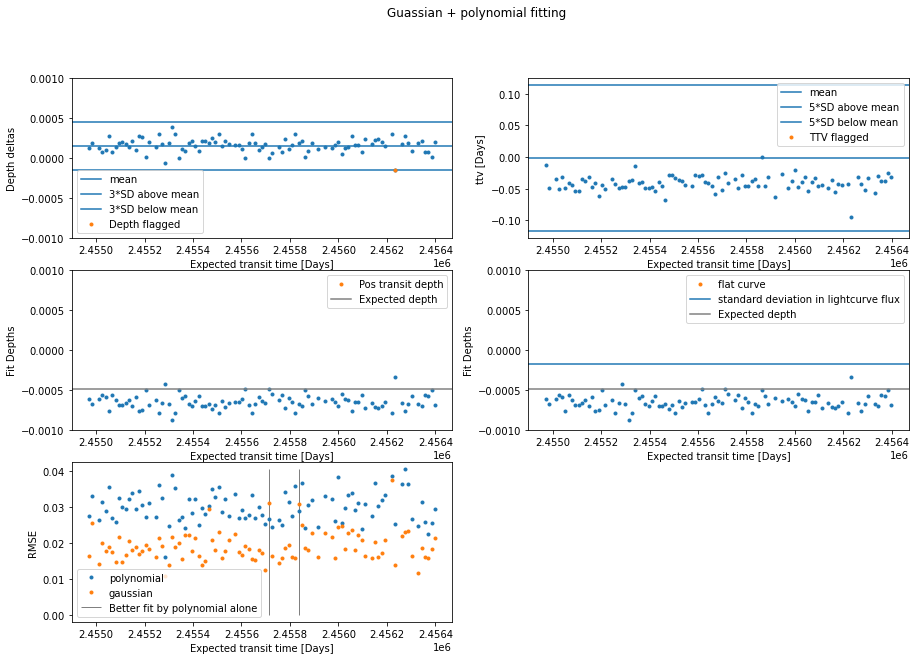

In [49]:
# visualize what is flagged
plt.figure(figsize = [15,10])
plt.subplot(321)
plt.plot(expected_midpoints, delta_depths_gp, '.')
plt.axhline(mean_delta_depth_gp, label = 'mean')
plt.axhline(mean_delta_depth_gp + depth_threshold*sd_delta_depth_gp,  label = str(depth_threshold) + '*SD above mean')
plt.axhline(mean_delta_depth_gp - depth_threshold*sd_delta_depth_gp,  label = str(depth_threshold) + '*SD below mean')
plt.plot(expected_midpoints[depth_flag_gp], delta_depths_gp[depth_flag_gp], '.', label = 'Depth flagged')
plt.ylabel('Depth deltas')
plt.xlabel('Expected transit time [Days]')
plt.ylim([-0.001, 0.001])
#plt.title('Guassian + polynomial fitting')
plt.legend()
''''
plt.subplot(122)
plt.plot(expected_midpoints, delta_depths_k, '.')
plt.axhline(mean_delta_depth_k, label = 'mean')
plt.axhline(mean_delta_depth_k + depth_threshold*sd_delta_depth_k,  label = str(depth_threshold) + '*SD above mean')
plt.axhline(mean_delta_depth_k - depth_threshold*sd_delta_depth_k,  label = str(depth_threshold) + '*SD below mean')
plt.plot(expected_midpoints[depth_flag_k], delta_depths_k[depth_flag_k], '.', label = 'flagged')
plt.ylabel('Depth deltas')
plt.xlabel('Expected transit time [Days]')
plt.title('ktransit fitting')
plt.legend() 
'''

#plt.figure(figsize = [15,4])
plt.subplot(322)
plt.plot(expected_midpoints, delta_midpoints_gp, '.')
plt.ylabel('ttv [Days]')
plt.xlabel('Expected transit time [Days]')
plt.axhline(mean_ttv_gp, label = 'mean')
plt.axhline(mean_ttv_gp + ttv_threshold*sd_ttv_gp,  label = str(ttv_threshold) + '*SD above mean')
plt.axhline(mean_ttv_gp - ttv_threshold*sd_ttv_gp,  label = str(ttv_threshold) +'*SD below mean')
plt.plot(expected_midpoints[tt_flag_gp], delta_midpoints_gp[tt_flag_gp], '.', label = 'TTV flagged')
#plt.title('Guassian + polynomial fitting')
plt.legend()
''''
plt.subplot(122)
plt.plot(expected_midpoints, delta_midpoints_k, '.')
plt.ylabel('ttv [Days]')
plt.xlabel('Expected transit time [Days]')
plt.axhline(mean_ttv_k, label = 'mean')
plt.axhline(mean_ttv_k + ttv_threshold*sd_ttv_k,  label = str(ttv_threshold) +'*SD above mean')
plt.axhline(mean_ttv_k - ttv_threshold*sd_ttv_k,  label = str(ttv_threshold) +'*SD below mean')
plt.plot(expected_midpoints[tt_flag_k], delta_midpoints_k[tt_flag_k], '.', label = 'flagged')
plt.title('ktransit fitting')
plt.legend()
'''


#plt.figure(figsize = [15,4])
plt.subplot(323)
plt.plot(expected_midpoints, depths_gp, '.')
plt.plot(expected_midpoints[pos_depth_flag_gp], depths_gp[pos_depth_flag_gp], '.', label = 'Pos transit depth')
plt.axhline(expected_depth, label = 'Expected depth', color = 'gray')
plt.ylabel('Fit Depths')
plt.xlabel('Expected transit time [Days]')
#plt.title('Guassian + polynomial fitting')
plt.ylim([-0.001, 0.001])
plt.legend()
''''
plt.subplot(122)
plt.plot(expected_midpoints, delta_depths_k, '.')
plt.plot(expected_midpoints[pos_depth_flag_k], delta_depths_k[pos_depth_flag_k], '.', label = 'Pos transit depth')
plt.ylabel('Depth deltas')
plt.xlabel('Expected transit time [Days]')
plt.title('ktransit fitting')
plt.legend()
'''
#plt.figure(figsize = [15,4])
plt.subplot(324)
plt.plot(expected_midpoints, depths_gp, '.')
plt.plot(expected_midpoints[flat_curve_flag_gp], depths_gp[flat_curve_flag_gp], '.', label = 'flat curve')
plt.axhline(-flux_SD, label = 'standard deviation in lightcurve flux')
plt.axhline(expected_depth, label = 'Expected depth', color = 'gray')
plt.ylabel('Fit Depths')
plt.xlabel('Expected transit time [Days]')
#plt.title('Guassian + polynomial fitting')
plt.ylim([-0.001, 0.001])
plt.legend()
''''
plt.subplot(122)
plt.plot(expected_midpoints, delta_depths_k, '.')
plt.plot(expected_midpoints[flat_curve_flag_k], delta_depths_k[flat_curve_flag_k], '.', label = 'flat curve')
plt.ylabel('Depth deltas')
plt.xlabel('Expected transit time [Days]')
plt.title('ktransit fitting')
plt.legend()
'''

plt.subplot(325)
plt.plot(expected_midpoints, chi_sq_arr_p, '.', label = 'polynomial')
plt.plot(expected_midpoints, chi_sq_arr_g, '.', label = 'gaussian')
plt.vlines(expected_midpoints[flat_curve_flag_2_gp], ymin = 0, ymax = np.nanmax(chi_sq_arr_p), linewidth = 1, color = 'gray', label = 'Better fit by polynomial alone')
plt.ylabel('RMSE')
plt.xlabel('Expected transit time [Days]')
#plt.title('Guassian + polynomial fitting')
plt.legend()

plt.suptitle('Guassian + polynomial fitting')

Midpoints RMS values: 
    ktransit: 9.11e-03
    gaussian: 1.22e-02
Depths RMS values: 
    ktransit: 5.17e-05
    gaussian: 8.64e-05
Delta midpoints mean offset values: 
    ktransit: -5.01e-03
    gaussian: 5.50e-04
Delta depths mean offset values: 
    ktransit: 9.40e-21
    gaussian: -5.89e-21


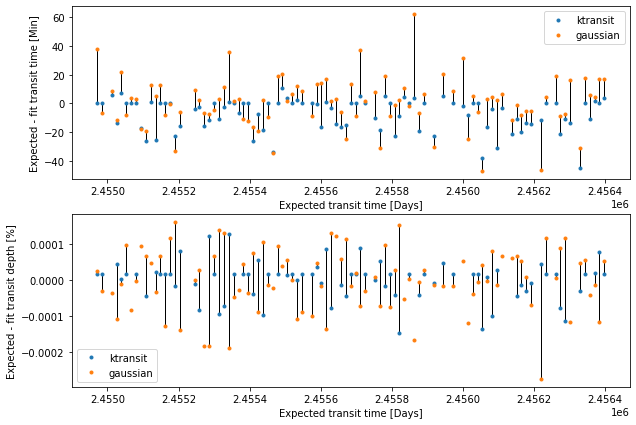

In [148]:
# make O-C plots (expected - observed transit times as a functions of expected)

plt.figure(figsize = [10,7])
plt.subplot(211)
plt.plot(expected_midpoints, delta_midpoints_k * 1440, '.', label = 'ktransit')
plt.plot(expected_midpoints, delta_midpoints_g * 1440, '.', label = 'gaussian')
plt.vlines(x = expected_midpoints, ymin = delta_midpoints_g* 1440, ymax = delta_midpoints_k* 1440, color = 'k', lw = 1)
plt.legend()
plt.xlabel('Expected transit time [Days]'); plt.ylabel('Expected - fit transit time [Min]')

plt.subplot(212)
plt.plot(expected_midpoints, delta_depths_k, '.', label = 'ktransit')
plt.plot(expected_midpoints, delta_depths_g, '.', label = 'gaussian')
#plt.plot(expected_midpoints, expected_depth - (- transit_depth_arr_k), '.', label = 'ktransit')
#plt.plot(expected_midpoints, expected_depth - depths_g, '.', label = 'gaussian')
plt.vlines(x = expected_midpoints, ymin = delta_depths_k, ymax = delta_depths_g, color = 'k', lw = 1)
#plt.axhline(expected_depth, label = 'Expected depth from radii')
plt.xlabel('Expected transit time [Days]'); plt.ylabel('Expected - fit transit depth [%]')

plt.legend()
#plt.suptitle('ktransit fitting')


midpoints_RMS_g = np.sqrt(np.nanmean(delta_midpoints_g**2))
midpoints_RMS_k = np.sqrt(np.nanmean(delta_midpoints_k**2))
depths_RMS_g = np.sqrt(np.nanmean(delta_depths_g**2))
depths_RMS_k = np.sqrt(np.nanmean(delta_depths_k**2))
print('Midpoints RMS values: ')
print('    ktransit: ' + "{:.2e}".format(np.nanmean(midpoints_RMS_k))) #str(np.round(midpoints_RMS_k,5)))
print('    gaussian: ' + "{:.2e}".format(np.nanmean(midpoints_RMS_g))) #str(np.round(midpoints_RMS_g,5)))
print('Depths RMS values: ')
print('    ktransit: ' + "{:.2e}".format(np.nanmean(depths_RMS_k))) #str(np.round(depths_RMS_k,5)))
print('    gaussian: ' + "{:.2e}".format(np.nanmean(depths_RMS_g))) #str(np.round(depths_RMS_g,5)))
print('Delta midpoints mean offset values: ')
print('    ktransit: ' + "{:.2e}".format(np.nanmean(delta_midpoints_k))) #str(np.round(np.nanmean(delta_midpoints_k),5)))
print('    gaussian: ' + "{:.2e}".format(np.nanmean(delta_midpoints_g)))#str(np.round(np.nanmean(delta_midpoints_g),5)))
print('Delta depths mean offset values: ')
print('    ktransit: ' + "{:.2e}".format(np.nanmean(delta_depths_k))) #str(np.round(np.nanmean(delta_depths_k),8)))
print('    gaussian: ' + "{:.2e}".format(np.nanmean(delta_depths_g)))#str(np.round(np.nanmean(delta_depths_g),8)))

# CODE SNIPPETS FOR TESTING BELOW HERE

(2456296.874, 2456334.318)

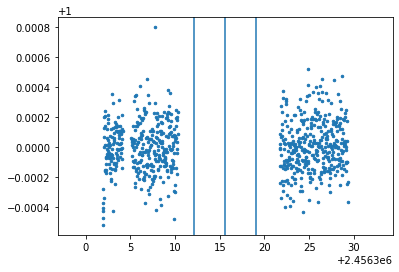

In [304]:
transit_idx = 9
low_bound = t0 + period * transit_idx - period    # /4 is somewhat arbitrary
up_bound = t0 + period * transit_idx + period
interval = (low_bound < time)*(time < up_bound)
plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
plt.axvline(t0 + period * transit_idx - period/4)
plt.axvline(t0 + period * transit_idx + period/4)
plt.axvline(t0+period * transit_idx)
plt.xlim([low_bound-5, up_bound + 5])

In [123]:
# does ktransit oupout errors?

fitT = FitTransit()
fitT.add_guess_star()    
fitT.add_guess_planet(period=period, impact=impact_parameter, T0=t0 + transit_idx*period, rprs=RpRs)
fitT.add_data(time=time, flux=flux - 1, ferr=err)

vary_star = []                     # free stellar parameters
vary_planet = (['T0',  'rprs'])    # free planetary parameters

fitT.free_parameters(vary_star, vary_planet)
fitT.do_fit()                      # run the fitting
fit_t0 = fitT.fitresultplanets['pnum0']['T0']
fit_rprs = fitT.fitresultplanets['pnum0']['rprs']

fitvalstar = [fitT.starguess_d[k] for k in fitT.fitparstar]
fitvalplanet = []
for i in range(fitT.nplanets):
    pdic = fitT.planetguess_d['pnum' + str(i)]
    fitvalplanet = np.r_[fitvalplanet,
    [pdic[k] for k in fitT.fitparplanet]]
fitpars = np.r_[fitvalstar,fitvalplanet]

fitT.fitout
pfit = fitT.fitout[0]
pcov = fitT.fitout[1]

if (len(flux) > len(fitpars)) and pcov is not None:
        s_sq = (fitT.ret_lstsq(pfit, time, flux)**2).sum()/(len(flux)-len(fitpars))
        pcov = pcov * s_sq
else:
        pcov = np.inf

error = [] 
for i in range(len(pfit)):
    try:
      error.append(np.absolute(pcov[i][i])**0.5)
    except:
      error.append( 0.00 )

pfit_leastsq = pfit
perr_leastsq = np.array(error)


TypeError: ret_lstsq() takes 2 positional arguments but 4 were given

1764


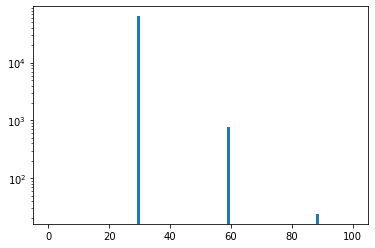

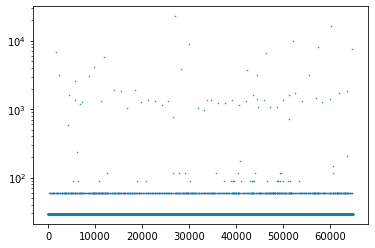

In [330]:
# check the cadence and varaibility in dt from the lightcurve itself

dts = np.diff(time * 24*60) #Min
plt.figure(); plt.hist(dts, bins = np.linspace(0,100,100)); plt.yscale('log'); 
plt.figure(); plt.plot(dts,'.', markersize = 1); plt.yscale('log'); 
print(cadence)

1

0.00017572577

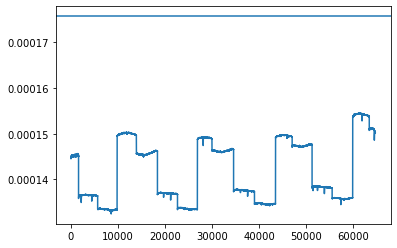

In [347]:
plt.figure(); plt.plot(flux_err)
plt.axhline(np.std(flux))
np.std(flux)